Install the mesa framework before running the python script

In [1]:
!pip install mesa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 809.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

<ipython-input-4-b7836c1c4ea3>:24: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)
<ipython-input-4-b7836c1c4ea3>:24: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)
<ipython-input-4-b7836c1c4ea3>:24: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)
<ipython-input-4-b7836c1c4ea3>:24: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)
<ipython-input-4-b7836c1c4ea3>:24: FutureWarning: Th

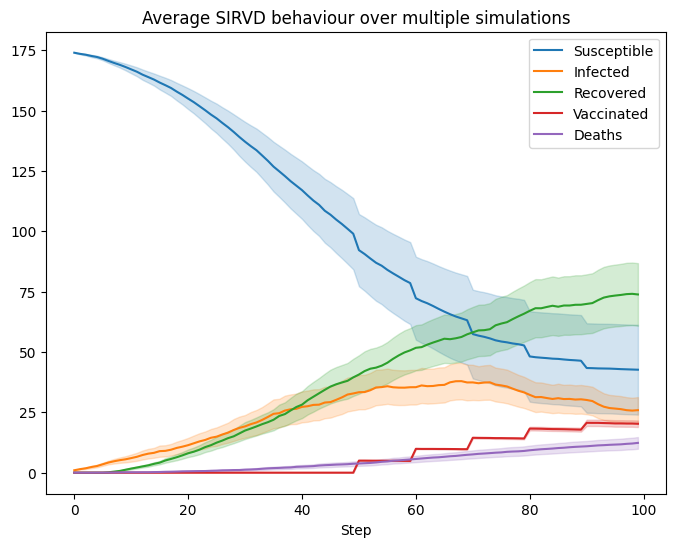

In [4]:
import matplotlib
import mesa
import random
import pandas as pd
import enum
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

class HealthStatus:
    SUSCEPTIBLE = 0
    INFECTED = 1
    RECOVERED = 2
    VACCINATED = 3

# Init the agents
class CovidAgent(Agent):
    def __init__(self, unique_id, model, xInit, yInit, destinations=[]):
        super().__init__(unique_id, model)
        self.initial_position = (xInit, yInit)
        self.health_status = HealthStatus.SUSCEPTIBLE
        self.target_position = None
        self.destinations = destinations
        self.infection_time = 0
        self.infected_at = 0
        self.stay_at_home = None

    def step(self):
        self.check()
        self.interact()
        self.move()

    def check(self):
        np.random.seed = self.random.seed
        # random recover time
        rand_treatment = random.randint(self.model.incubation_period, self.model.treatment_period)
        if self.health_status == HealthStatus.INFECTED:
            mortality_rate = self.model.mortality_rate
            if np.random.choice([0, 1], p=[mortality_rate, 1-mortality_rate]) == 0:
                self.model.schedule.remove(self)
            elif self.model.schedule.time - self.infected_at >= rand_treatment:
                self.health_status = HealthStatus.RECOVERED

    def move(self):
        self.set_target_position()
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        new_position = self.move_position(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def interact(self):
        neighbors = self.model.grid.get_cell_list_contents([self.pos])
        for n in neighbors:
            if self.health_status == HealthStatus.INFECTED and n.health_status != HealthStatus.INFECTED:
                if n.health_status == HealthStatus.VACCINATED:
                    infect = random.random() <= self.model.infection_prob * 0.05
                else:
                    infect = random.random() <= self.model.infection_prob
                if infect:
                    n.health_status = HealthStatus.INFECTED
                    n.infected_at = self.model.schedule.time

    def set_target_position(self):
        if self.pos == self.initial_position:
            self.target_position = self.random.choice(self.destinations)
        elif self.pos == self.target_position:
            self.target_position = self.initial_position

    def move_position(self, possible_steps):
        if self.health_status == HealthStatus.INFECTED:
            symptoms = self.model.schedule.time - self.infection_time >= self.model.incubation_period
            if self.pos == self.initial_position and symptoms and self.stay_at_home:
                return self.initial_position
            elif self.pos != self.initial_position and symptoms and self.stay_at_home:
                self.target_position = self.initial_position
        return random.choice(possible_steps)


class CovidModel(Model):
    def __init__(self, P, width, height, infection_prob, mortality_rate, incubation_period, treatment_period, stay_at_home, destination_size, vaccination_interval, vaccination_batch_size, vaccination_start, seed=None):
        self.population_size = P
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.infection_prob = infection_prob
        self.mortality_rate = mortality_rate
        self.incubation_period = incubation_period
        self.treatment_period = treatment_period
        self.stay_at_home = stay_at_home
        self.vaccination_interval = vaccination_interval
        self.vaccination_batch_size = vaccination_batch_size
        self.vaccination_start = vaccination_start
        self.deaths = 0
        self.running = True

        self.destinations = []
        for _ in range(destination_size):
            self.destinations.append((self.random.randrange(self.grid.width), self.random.randrange(self.grid.height)))

        first_infected_index = random.randint(0, self.population_size - 1)
        for i in range(self.population_size):
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            agent_gen = CovidAgent(i, self, x, y, self.destinations)
            if i == first_infected_index:
                agent_gen.health_status = HealthStatus.INFECTED
            self.schedule.add(agent_gen)
            self.grid.place_agent(agent_gen, (x, y))

        self.datacollector = DataCollector(
            model_reporters={"S": compute_S, "I": compute_I, "R": compute_R, "V": compute_V, "D": compute_D},
            agent_reporters={"Status": "health_status", "Position": "pos"}
        )

    def step(self):
        if self.schedule.time >= self.vaccination_start and self.schedule.time % self.vaccination_interval == 0:
            self.perform_vaccination_drive()

        self.datacollector.collect(self)
        self.schedule.step()

    def perform_vaccination_drive(self):
        susceptible_agents = [agent for agent in self.schedule.agents if agent.health_status == HealthStatus.SUSCEPTIBLE]
        if len(susceptible_agents) > 0:
            batch_size = min(self.vaccination_batch_size, len(susceptible_agents))
            vaccinated_agents = self.random.sample(susceptible_agents, batch_size)
            for agent in vaccinated_agents:
                agent.health_status = HealthStatus.VACCINATED

def compute_S(model):
    return len([agent.health_status for agent in model.schedule.agents if agent.health_status == HealthStatus.SUSCEPTIBLE])

def compute_I(model):
    return len([agent.health_status for agent in model.schedule.agents if agent.health_status == HealthStatus.INFECTED])

def compute_R(model):
    return len([agent.health_status for agent in model.schedule.agents if agent.health_status == HealthStatus.RECOVERED])

def compute_V(model):
    return len([agent.health_status for agent in model.schedule.agents if agent.health_status == HealthStatus.VACCINATED])

def compute_D(model):
    return model.population_size - len(model.schedule.agents)

def run_simulation(batch, steps, pop_size, width, height, inf_prob, mort_rate, inc_period, treat_period, stay_home, dest_size, vacc_interval, vacc_batch_size, vacc_start):
    model = CovidModel(pop_size, width, height, inf_prob, mort_rate, inc_period, treat_period, stay_home, dest_size, vacc_interval, vacc_batch_size, vacc_start, seed=batch)
    for _ in range(steps):
        model.step()
    return model.datacollector.get_model_vars_dataframe()

# Parameters
simulation_steps = 100
simulation_population_size = 175
maximum_X = 20
maximum_Y = 20
simulation_infection_prob = 0.7
simulation_mortality_rate = 0.005
simulation_incubation_period = 5
simulation_treatment_period = 14
simulation_stay_at_home = True
simulation_destination_size = 10
vaccination_interval = 10
vaccination_batch_size = 5
vaccination_start = 50
num_batches = 50

# Run multiple simulations and collect results
results = []
for batch in range(num_batches):
    df = run_simulation(batch, simulation_steps, simulation_population_size, maximum_X, maximum_Y,
                        simulation_infection_prob, simulation_mortality_rate,
                        simulation_incubation_period, simulation_treatment_period, simulation_stay_at_home,
                        simulation_destination_size, vaccination_interval, vaccination_batch_size, vaccination_start)
    df['Batch'] = batch
    results.append(df)

# Combine results into a single DataFrame
all_results = pd.concat(results)

# Compute average values for each step
average_results = all_results.groupby(all_results.index).mean()

# Compute standard error and confidence intervals
std_error = all_results.groupby(all_results.index).sem()
degrees_freedom = num_batches - 1
confidence_level = 0.95
t_critical = stats.t.ppf((1 + confidence_level) / 2, degrees_freedom)
margin_of_error = t_critical * std_error

# Plot average results with confidence intervals
fig, ax = plt.subplots(1, figsize=(8, 6))
ax.set_xlabel('Step')
ax.set_title('Average SIRVD behaviour over multiple simulations')
ax.plot(range(simulation_steps), average_results['S'], label='Susceptible', color='tab:blue')
ax.fill_between(range(simulation_steps),
                average_results['S'] - margin_of_error['S'],
                average_results['S'] + margin_of_error['S'],
                color='tab:blue', alpha=0.2)
ax.plot(range(simulation_steps), average_results['I'], label='Infected', color='tab:orange')
ax.fill_between(range(simulation_steps),
                average_results['I'] - margin_of_error['I'],
                average_results['I'] + margin_of_error['I'],
                color='tab:orange', alpha=0.2)
ax.plot(range(simulation_steps), average_results['R'], label='Recovered', color='tab:green')
ax.fill_between(range(simulation_steps), average_results['R'] - margin_of_error['R'],
            average_results['R'] + margin_of_error['R'],
            color='tab:green', alpha=0.2)
ax.plot(range(simulation_steps), average_results['V'], label='Vaccinated', color='tab:red')
ax.fill_between(range(simulation_steps),
                average_results['V'] - margin_of_error['V'],
                average_results['V'] + margin_of_error['V'],
                color='tab:red', alpha=0.2)
ax.plot(range(simulation_steps), average_results['D'], label='Deaths', color='tab:purple')
ax.fill_between(range(simulation_steps),
                average_results['D'] - margin_of_error['D'],
                average_results['D'] + margin_of_error['D'],
                color='tab:purple', alpha=0.2)
ax.legend()

plt.show()